In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import os

In [21]:
import pandas as pd
import os

In [22]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [23]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  # Disable first GPU
  tf.config.set_visible_devices(physical_devices[1:], 'GPU')
  logical_devices = tf.config.list_logical_devices('GPU')
  # Logical device was not created for first GPU
  assert len(logical_devices) == len(physical_devices) - 1
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [24]:
#GPU memory too small for model training
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]

In [25]:
def resize_fun(x):
    return tf.image.resize_with_crop_or_pad(x, target_height=640,target_width=640)

In [26]:
def create_gen(df, directory=os.path.join(os.path.dirname(os.getcwd()), 'ava-data', 'AVA_dataset','images_ext','images')):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    return datagen.flow_from_dataframe(df, 
                                       directory=directory, batch_size=32,
                                       x_col='data', y_col='score', class_mode='raw', 
                                       target_size=(640,640), resizing_function=resize_fun)

In [7]:
ava = pd.read_csv('../ava-data/AVA_dataset/AVA.txt', sep=' ', names=['index', 'ID', *['r'+str(x) for x in range(1,11)], 't1', 't2', 'CID'])

In [27]:
try:
    test_df = pd.read_csv('test_df', index_col=0)
except:
    test_df = pd.DataFrame(columns=['data', 'score'])
    with open('../ava-data/AVA_dataset/aesthetics_image_lists/generic_ss_train.jpgl') as file:
        for line in file.readlines():
            try:
                fID = line.strip()
                #print(fID),print(type(fID))
                raw_scores = ava.loc[ava.ID == int(fID), 'r1':'r10'].values
                score = raw_scores.dot(np.arange(1,11))/raw_scores.sum()
                test_df = test_df.append({'data':str(fID)+'.jpg', 'score':np.float32(score[0])}, ignore_index=True)
            except:
                continue

In [28]:
try:
    train_df = pd.read_csv('train_df', index_col=0)
except:
    train_df = pd.DataFrame(columns=['data', 'score'])
    with open('../ava-data/AVA_dataset/aesthetics_image_lists/generic_test.jpgl') as file:
        for line in file.readlines():
            try:
                fID = line.strip()
                #print(fID),print(type(fID))
                raw_scores = ava.loc[ava.ID == int(fID), 'r1':'r10'].values
                score = raw_scores.dot(np.arange(1,11))/raw_scores.sum()
                train_df = train_df.append({'data':str(fID)+'.jpg', 'score':np.float32(score[0])}, ignore_index=True)
            except:
                continue

In [29]:
training_gen = create_gen(train_df)

Found 19929 validated image filenames.


C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:280: UserWarning: Found 1 invalid image filename(s) in x_col="data". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [30]:
val_gen = create_gen(test_df)

Found 2494 validated image filenames.


In [31]:
im_batch, label_batch = next(training_gen)

In [32]:
MNv2_base = tf.keras.applications.MobileNetV2(input_shape=(640, 640, 3), alpha=1, include_top=False, weights=None)

In [33]:
MNv2_base_batch = MNv2_base(im_batch)

In [34]:
MNv2_avg_pool = tf.keras.layers.GlobalAveragePooling2D()
MNv2_avg_pool_batch = MNv2_avg_pool(MNv2_base_batch)

In [35]:
MNv2_dense = tf.keras.layers.Dense(1)
MNv2_dense_batch = MNv2_dense(MNv2_avg_pool_batch)

In [36]:
MNv2_model = tf.keras.models.Sequential([MNv2_base, MNv2_avg_pool, MNv2_dense])

In [55]:
initial_learning_rate = 0.45
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=623,
    decay_rate=0.98,
    staircase=True)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule, momentum=0.9)
tqdm_callback = tfa.callbacks.TQDMProgressBar()

checkpoint_filepath = os.path.join(os.getcwd(), 'checkpoints', 'test',' {epoch:02d}.hdf5')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=False)

In [38]:
MNv2_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['MAE'])

In [42]:
loss, MAE = MNv2_model.evaluate(val_gen, steps=78)

  ...
    to  
  ['...']
 8/78 [==>...........................] - ETA: 6:01 - loss: 11962518.6250 - MAE: 3458.6826

C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 13120. Skipping tag 60219
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65535 bytes but only got 0. Skipping tag 65535
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5505025 bytes but only got 0. Skipping tag 2360
  " Skipping tag %s" % (size, len(data), tag)


78/78 [==============================] - 392s 5s/step - loss: 11961500.7051 - MAE: 3458.5361


In [58]:
MNv2_model.fit(x=training_gen, epochs=5, validation_data=val_gen, callbacks=[model_checkpoint_callback, tqdm_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 623 steps, validate for 78 steps


Epoch 1/5


Epoch 1/5
319/623 [==============>...............] - ETA: 3:34:11 - loss: 2.7261 - MAE: 1.3695

C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 211288080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131073 bytes but only got 10470. Skipping tag 582
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 196867 bytes but only got 10474. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 5. 
  warnings.warn(str(msg))


459/623 [=====================>........] - ETA: 1:55:35 - loss: 2.7397 - MAE: 1.3705

C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 21701 bytes but only got 816. Skipping tag 700
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5176 bytes but only got 816. Skipping tag 34377
  " Skipping tag %s" % (size, len(data), tag)


622/623 [============================>.] - ETA: 42s - loss: 2.7288 - MAE: 1.3648 

C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 13120. Skipping tag 60219
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65535 bytes but only got 0. Skipping tag 65535
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5505025 bytes but only got 0. Skipping tag 2360
  " Skipping tag %s" % (size, len(data), tag)



623/623 [==============================] - 26751s 43s/step - loss: 2.7321 - MAE: 1.3659 - val_loss: 29760.3222 - val_MAE: 172.4595
Epoch 2/5


Epoch 2/5
623/623 [==============================] - 26800s 43s/step - loss: 2.5776 - MAE: 1.3185 - val_loss: 931.2492 - val_MAE: 30.5049
Epoch 3/5


Epoch 3/5
623/623 [==============================] - 26864s 43s/step - loss: 2.5931 - MAE: 1.3314 - val_loss: 0.7020 - val_MAE: 0.6697
Epoch 4/5


Epoch 4/5
623/623 [==============================] - 26810s 43s/step - loss: 2.6831 - MAE: 1.3378 - val_loss: 1.3513 - val_MAE: 0.9679
Epoch 5/5


Epoch 5/5
623/623 [==============================] - 26762s 43s/step - loss: 2.5079 - MAE: 1.3045 - val_loss: 2.3882 - val_MAE: 1.3729



In [69]:
lr = optimizer._decayed_lr(tf.float32)

In [59]:
history = _58

In [62]:
import matplotlib.pyplot as plt

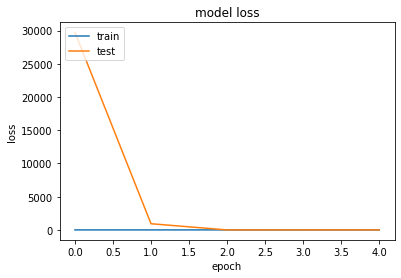

In [68]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

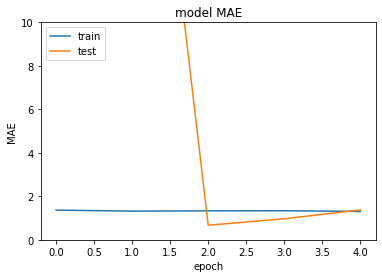

In [66]:
plt.plot(history.history['MAE'])
plt.plot(history.history['val_MAE'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim(0,10)
plt.show()

In [71]:
MNv2_model.save(os.path.join(os.getcwd(), 'checkpoints', 'trial', 'final'))

INFO:tensorflow:Assets written to: C:\Users\foley\projects\Mobile-Image-Aesthetics\checkpoints\trial\final\assets


## Corrupt image error code

In [20]:
MNv2_model.fit(x=training_gen, epochs=5, validation_data=val_gen, callbacks=[model_checkpoint_callback, tqdm_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 623 steps, validate for 78 steps


Epoch 1/5


Epoch 1/5
235/623 [==========>...................] - ETA: 4:33:51 - loss: 28477.0915 - MAE: 34.7648

C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 211288080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131073 bytes but only got 10470. Skipping tag 582
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 196867 bytes but only got 10474. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 5. 
  warnings.warn(str(msg))


554/623 [=========================>....] - ETA: 48:33 - loss: 12296.0367 - MAE: 23.2126


KeyError: 'val_loss'

## Corrupt image search

In [16]:
import cv2
from skimage import io
from tqdm import tqdm
missing_list = []
error_list1 = []
error_list2 = []
path = os.path.join(os.path.dirname(os.getcwd()), 'ava-data', 'AVA_dataset','images_ext','images')
for image in tqdm(ava.ID):
    img_path = os.path.join(path, str(image) + '.jpg')
    
    cv_img = cv2.imread(img_path)
    
    if cv_img is None:
        missing_list.append(image)
        continue
    try:
        shape = cv_img.shape
    except:
        error_list1.append(img_path)
    try:
        sk_img = io.imread(img_path)
        shape = sk_img.shape
    except:
        cv2.imwrite(img_path, cv_img)
        error_list2.append(img_path)

 10%|███▌                               | 26358/255530 [08:24<58:23, 65.41it/s]C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
 14%|████▋                            | 35815/255530 [11:13<1:04:28, 56.80it/s]C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11072 bytes but only got 761. Skipping tag 700
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8134 bytes but only got 761. Skipping tag 34377
  " Skipping tag %s" % (size, len(data), tag)
 15%|█████                            | 38976/255530 [12:15<1:04:04, 56.33it/s]C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py

 50%|████████████████▉                 | 127031/255530 [40:09<35:07, 60.96it/s]C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 22149 bytes but only got 816. Skipping tag 700
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5874 bytes but only got 816. Skipping tag 34377
  " Skipping tag %s" % (size, len(data), tag)
 54%|██████████████████▍               | 138197/255530 [43:25<36:14, 53.96it/s]C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18481152 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly c

 95%|██████████████████████████████▍ | 242651/255530 [1:14:31<03:39, 58.64it/s]C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11046 bytes but only got 749. Skipping tag 700
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\foley\anaconda3\envs\tensorflow2PC\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 9664 bytes but only got 749. Skipping tag 34377
  " Skipping tag %s" % (size, len(data), tag)
100%|████████████████████████████████| 255530/255530 [1:18:26<00:00, 54.29it/s]


In [17]:
len(missing_list)

22

In [18]:
len(error_list1)

0

In [19]:
len(error_list2)

6

In [48]:
corrupt_df = pd.DataFrame(columns=['ID', 'miss', 'corr'])

In [ ]:
from PIL import Image
from tqdm import tqdm
path = os.path.join(os.path.dirname(os.getcwd()), 'ava-data', 'AVA_dataset','images_ext','images')
for image in tqdm(ava.ID):
    try:
        try:
            im = Image.open(os.path.join(path, str(image)+'.jpg'))
        except:
            corrupt_df = corrupt_df.append({'ID': image, 'miss':True, 'corr':False}, ignore_index=True)
            continue
        im.getdata()
    except:
        corrupt_df = corrupt_df.append({'ID': image, 'miss':False, 'corr':True}, ignore_index=True)

  3%|█▏                                  | 8395/255530 [00:52<41:32, 99.14it/s]

In [54]:
corrupt_df

,ID,miss,corr
0,953619,True,False
1,953958,True,False
2,954184,True,False
3,954113,True,False
4,953980,True,False
5,954175,True,False
6,953349,True,False
7,953645,True,False
8,953897,True,False
9,953841,True,False


In [61]:
im = Image.open(os.path.join(path, str(724198)+'.jpg'))
np.array(im.getdata())

(307200, 3)